In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from meteostat import Point, Hourly
from datetime import datetime
import seaborn as sns

In [2]:
def _read_data():
    _target_column_name = 'log_bike_count'
    data = pd.read_parquet(Path("data") / "train.parquet")
    # Sort by date first, so that time based cross-validation would produce correct results
    data = data.sort_values(["date", "counter_name"])
    y_array = data[_target_column_name].values
    X_df = data.drop([_target_column_name], axis=1)
    #"bike_count"
    return X_df, y_array

X_train, y_train = _read_data()

In [3]:
X_train

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude
400125,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,4.0,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233
408305,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,3.0,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233
87516,100036719-104036719,18 quai de l'Hôtel de Ville NO-SE,100036719,18 quai de l'Hôtel de Ville,0.0,2020-09-01 01:00:00,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020
98518,100036719-103036719,18 quai de l'Hôtel de Ville SE-NO,100036719,18 quai de l'Hôtel de Ville,1.0,2020-09-01 01:00:00,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020
875137,100063175-353277233,20 Avenue de Clichy NO-SE,100063175,20 Avenue de Clichy,7.0,2020-09-01 01:00:00,2020-07-22,"48.88529,2.32666",Y2H20073268,48.885290,2.326660
...,...,...,...,...,...,...,...,...,...,...,...
792857,100057329-103057329,Totem 85 quai d'Austerlitz SE-NO,100057329,Totem 85 quai d'Austerlitz,42.0,2021-09-09 23:00:00,2020-02-18,"48.84201,2.36729",YTH19111508,48.842010,2.367290
805182,100057380-104057380,Totem Cours la Reine E-O,100057380,Totem Cours la Reine,22.0,2021-09-09 23:00:00,2020-02-11,"48.86462,2.31444",YTH19111509,48.864620,2.314440
815218,100057380-103057380,Totem Cours la Reine O-E,100057380,Totem Cours la Reine,32.0,2021-09-09 23:00:00,2020-02-11,"48.86462,2.31444",YTH19111509,48.864620,2.314440
125979,100042374-110042374,Voie Georges Pompidou NE-SO,100042374,Voie Georges Pompidou,9.0,2021-09-09 23:00:00,2017-12-15,"48.8484,2.27586",Y2H21025335,48.848400,2.275860


In [4]:
from datetime import datetime
from meteostat import Point, Hourly

def _add_weather_data(X):
    X = X.copy()
    dfs = []

    for counter_id in X['counter_id'].unique():
        # Get the coordinates of the counter
        coordinates_counter = (
            X.loc[X['counter_id'] == counter_id, 'latitude'].values[0],
            X.loc[X['counter_id'] == counter_id, 'longitude'].values[0]
        )

        # Create a Point object with the counter's coordinates
        counter_point = Point(*coordinates_counter)

        # Define the time range (start and end dates)
        start = datetime(2020, 8, 1)
        end = datetime(2022, 1, 1)

        # Create a Hourly object and fetch the weather data
        weather_data = Hourly(counter_point, start, end)
        weather_data = weather_data.interpolate()
        weather_data = weather_data.fetch().shift(-1)
            #selected_columns = ['temp', 'rhum', 'wspd', 'prcp']
            #weather_data['prcp'] = weather_data['prcp'].fillna(method='ffill')
            #weather_data = weather_data[selected_columns].shift(-1)

        # Append counter_id to the weather_data DataFrame
        weather_data['counter_id'] = counter_id

        # Append the DataFrame to the list
        dfs.append(weather_data)

    # Concatenate all DataFrames into a single result_df
    result_df = pd.concat(dfs)
    
    # Convert 'time' index to 'date' column for merging
    result_df['date'] = result_df.index
    result_df['date'] = pd.to_datetime(result_df['date'])
    
    # Merge the result DataFrame with the original DataFrame on 'counter_id' and 'date'
    X = X.reset_index().merge(result_df, how='left', on=['counter_id', 'date']).set_index('index')

    X['extreme_condition'] = (
        (X['temp'] < X['temp'].quantile(0.015)) |
        (X['prcp'] > X['prcp'].quantile(0.98)) |
        (X['wspd'] > X['wspd'].quantile(0.99)) |
        (X['snow'] > X['snow'].quantile(0.9925))
    ).astype(int)

    return X

In [5]:
encoded_weather = _add_weather_data(X_train)


encoded_weather.iloc[:, -12:].describe().transpose()



,count,mean,std,min,25%,50%,75%,max
temp,496827.0,12.917651,6.873535,-6.4,7.9,12.5,17.8,34.1
dwpt,496827.0,7.092808,5.914998,-17.1,2.6,7.4,11.9,20.7
rhum,496827.0,70.014925,16.055418,1.0,59.0,73.0,83.0,100.0
prcp,496827.0,0.094353,0.450348,0.0,0.0,0.0,0.0,16.0
snow,471067.0,0.114124,1.491492,0.0,0.0,0.0,0.0,40.0
wdir,496827.0,185.027931,102.784438,0.0,80.0,200.0,260.0,360.0
wspd,496827.0,11.321847,5.111391,0.0,7.6,11.2,14.8,40.7
wpgt,496827.0,24.229969,11.135434,1.8,16.7,22.2,31.0,94.0
pres,496827.0,1016.411943,9.478953,972.2,1011.3,1017.9,1022.7,1039.5
tsun,392.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [6]:
encoded_weather['snow'].quantile(0.9925)

3.333333333333333

In [7]:
encoded_weather['prcp'].quantile(0.98)

1.0

In [8]:
encoded_weather['wspd'].quantile(0.5)

11.2

In [9]:
encoded_weather['extreme_condition'].value_counts()

extreme_condition
0    475995
1     20832
Name: count, dtype: int64

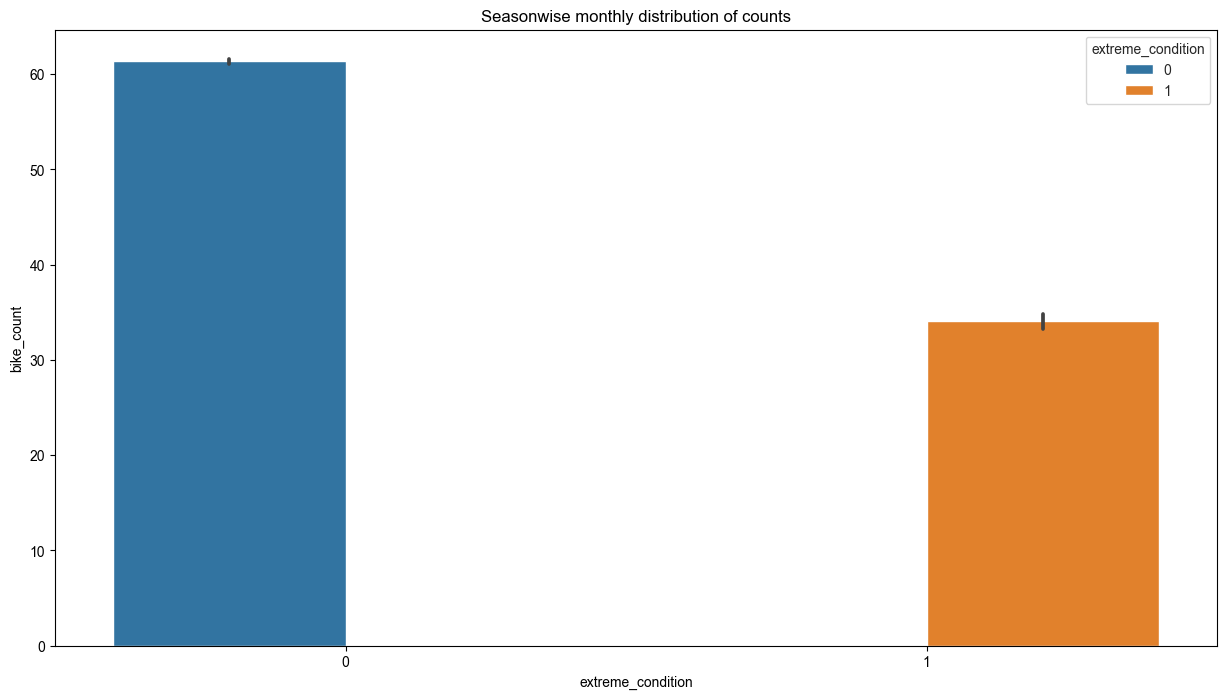

In [10]:
import seaborn as sns
%matplotlib inline

fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('white')
#Bar plot for seasonwise monthly distribution of counts
sns.barplot(x='extreme_condition',y='bike_count',data=encoded_weather,hue='extreme_condition',ax=ax)
ax.set_title('Seasonwise monthly distribution of counts')
plt.show()

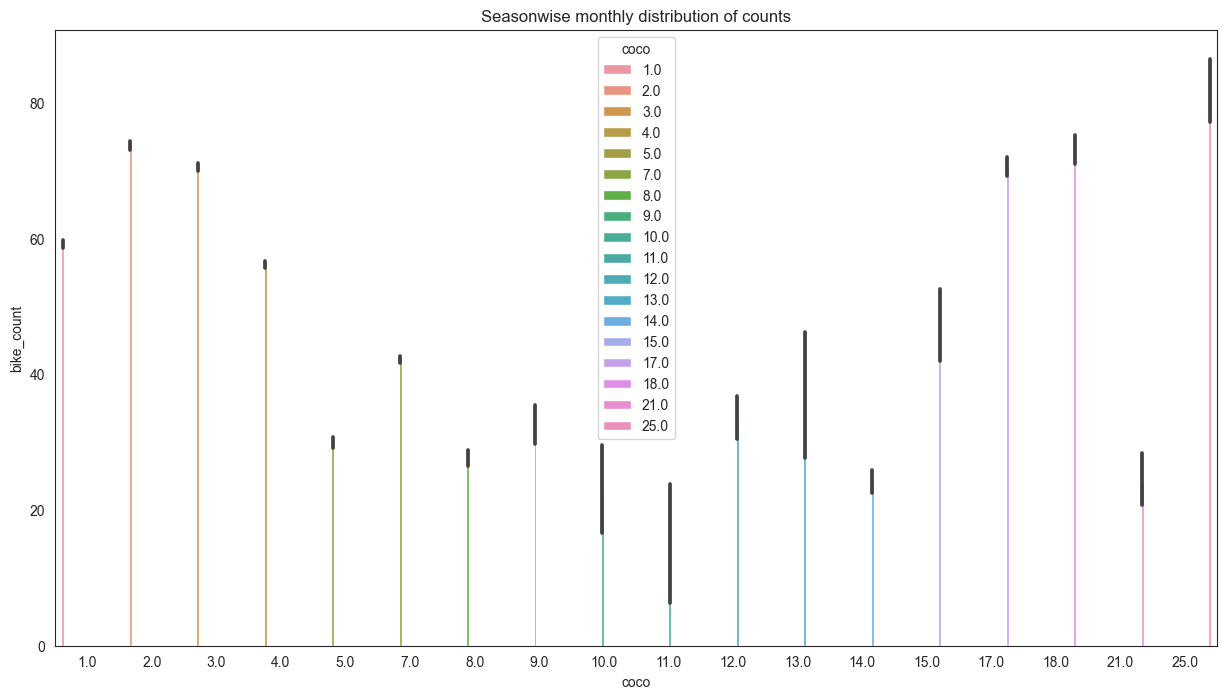

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('white')
#Bar plot for seasonwise monthly distribution of counts
sns.barplot(x='coco',y='bike_count',data=encoded_weather[['bike_count','coco']],hue='coco',ax=ax)
ax.set_title('Seasonwise monthly distribution of counts')
plt.show()

NameError: name 'result' is not defined

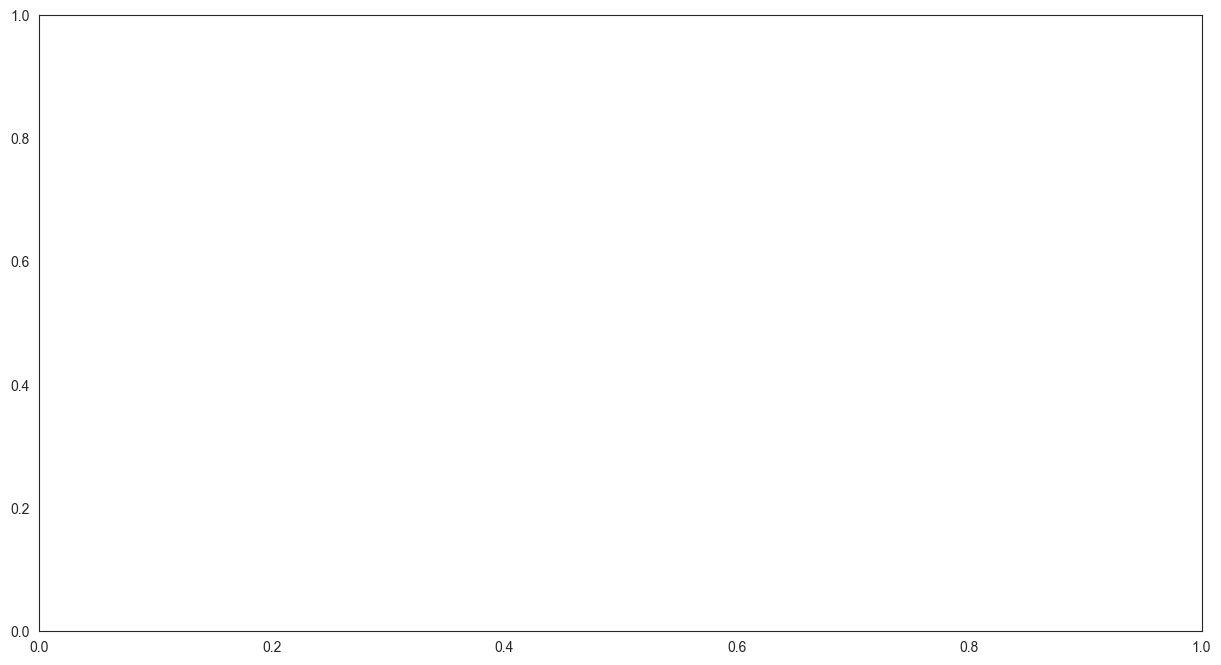

In [12]:
import seaborn as sns

fig,ax=plt.subplots(figsize=(15,8))
#Barplot for Holiday distribution of counts
sns.lineplot(data=result,x='temp',y='bike_count')
ax.set_title('Holiday wise distribution of counts')
plt.show()

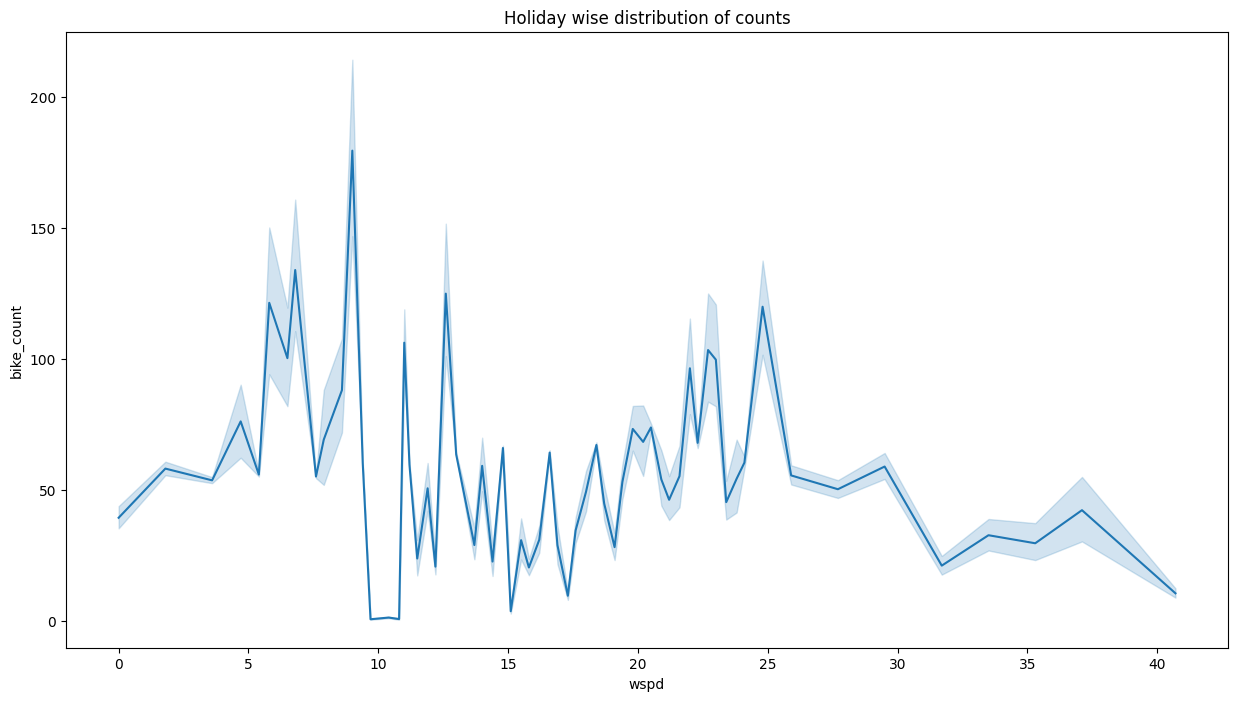

In [ ]:
fig,ax=plt.subplots(figsize=(15,8))
#Barplot for Holiday distribution of counts
sns.lineplot(data=result,x='wspd',y='bike_count')
ax.set_title('Holiday wise distribution of counts')
plt.show()